<h1>
    <br style ="font-family:UCL-SoM-Outline;color:#EA7600"> GROUP COURSEWORK </br> 
    </p>
</h1>

<div class="image">

     <img src="./figures/som_ft.png" width="70%"  align="right">
      <h4>
          <p style="font-size:18pt">MSING055 Predictive Analytics</p>
          <p style="font-size:18pt;font-family:UCL-SoM-Solid; color:#EA7600;"> Team Members: ** --Andrew Fyfe, Achilleas Athanasiou Fragkoulis, Kamil Tylinski, Timofey Cherkasov, Vasilis Francis-- ** </p> 
          <p style="font-size:18pt">Team Number: ** --2-- **</p>
      </h4>

</div>

In [1]:
# Preamble - Introducing libraries
import warnings
warnings.filterwarnings('ignore')

import sherlockml.filesystem as sfs
import pandas as pd
from pandas import read_csv  
from pandas import set_option
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
import sklearn
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import scale
import xgboost
import pandas_profiling
import seaborn as sns
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

# Insert custom functions library
import spotfunc as spotfunc_v2

In [2]:
%%time
# Read in data
data = pd.read_csv('cleaned_data.csv', low_memory=False)
print('Number of streams: ', len(data))

# Add datetime detail to data
spotfunc_v2.add_datetime_detail(data)

# Keep a copy of original data in case of changes made to dataframe
original_data = data.copy()

# Load playlist data
playlist_ids_and_titles = pd.read_csv('playlists_ids_and_titles.csv',encoding = 'latin-1',error_bad_lines=False,warn_bad_lines=False, index_col=None)

# Keep only those with 22 characters (data cleaning)
playlist_mapper = playlist_ids_and_titles[playlist_ids_and_titles.id.str.len()==22].drop_duplicates(['id'])

# Load artist data
new_artists = pd.read_csv('newartists2015onwards.csv',encoding = 'latin-1',error_bad_lines=False, warn_bad_lines=False, index_col=None)

Number of streams:  3805499
CPU times: user 47.4 s, sys: 5.08 s, total: 52.4 s
Wall time: 52.4 s


## CLEANING ARTIST DATA

In [3]:
# clean artist names in both dataframes
new_artists = spotfunc_v2.clean_artist_names(new_artists, 'LEGAL_NAME')
data = spotfunc_v2.clean_artist_names(data, 'artist_name')

# Intersect dataframes to keep only artists appearing from 2015 onwards in the original dataset
new_artists = new_artists.dropna(subset = ['COUNTRY_OF_ORIGIN_CODE', 'MAJOR_GENRE_CODE'])
data = data[data.cleaned_names.isin(new_artists.cleaned_names)]

# Match artist names with the cleaned names version
data['artist_name'] = data['cleaned_names']

# Generate the actual age of users based on birth year
data['age'] = data.year - data.birth_year

In [4]:
data.age.describe()

count    2.996741e+06
mean     2.642317e+01
std      1.073533e+01
min      0.000000e+00
25%      1.900000e+01
50%      2.300000e+01
75%      3.000000e+01
max      1.500000e+02
Name: age, dtype: float64

Stream count distribution over various attributes


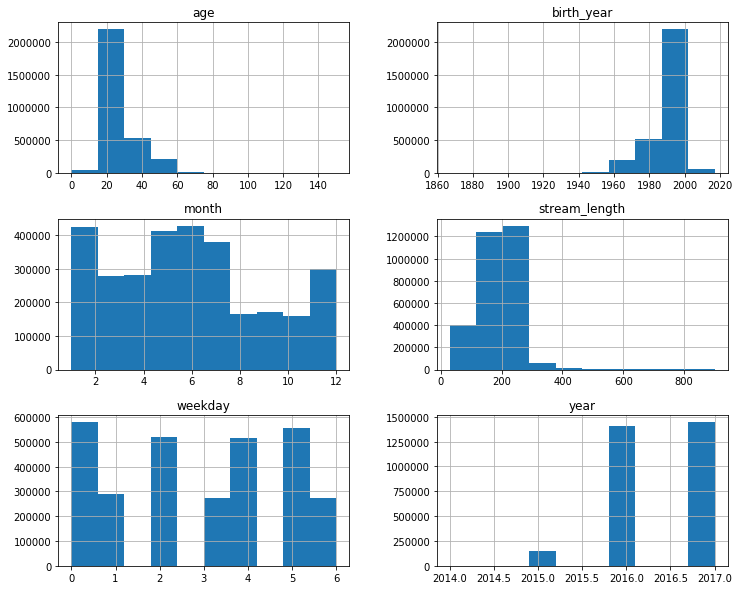

In [5]:
print('Stream count distribution over various attributes')
data2= data.filter(['birth_year','age','stream_length','month','year','weekday'], axis=1)
data2.hist(figsize = (12,10));
plt.show();

In [6]:
# See image below as this takes forever to run

#In a bit more detail for age
#sns.set()
#x = data['age'].dropna()
#ax = sns.distplot(x).set_title('Distribution by age')
#plt.ylabel("Fraction of the population")

<div class="image">

      <img src="./figures/Age_Density_ Plot.png" width="60%"  align="center">
    
      
</div>

In [7]:
# See image below as this takes forever to run

# BE MINDFUL THIS RUNS REALLY SLOW

#print('Density plots')
#data2.plot(kind='density' , subplots=True, layout=(3,3), sharex=False, figsize = (13,12));
#plt.show();

<div class="image">

      <img src="./figures/Density_Plots.png" width="60%"  align="center">
    
      
</div>

Box & Whiskers for each attribute to examine spread of values and medians


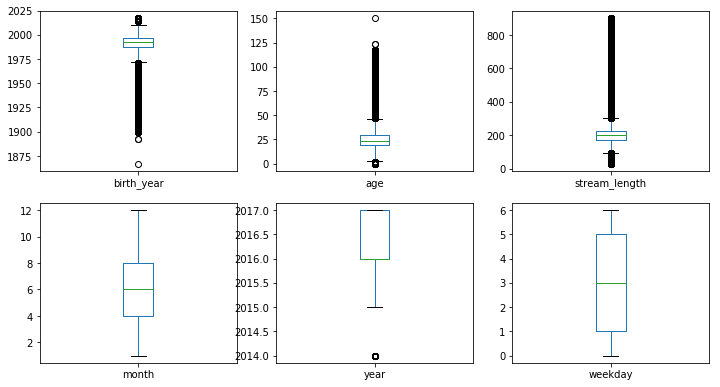

In [8]:
print('Box & Whiskers for each attribute to examine spread of values and medians')
data2.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize = (12,10)); 
plt.show();

In [9]:
# Calculate age skewness
skewness = round((data.age).skew(), 2)
skewness

2.31

Age is positively skewed. This is to be expected as there are plenty more younger users of spotify than older ones.

Cleaning the user's age data by removing those that have a zero age or those above the age of 100.  The streamed records left are those between the ages of 1 and 99.
A different way to deal with this would have been to impute these values 
instead with the respective age median value, but didn't have time to do this..

In [10]:
dat = data

# Drop streams for users whose age is 0
dat = dat[dat.age != 0]

# Count how many rows of data were discarded
unborn = len(data)-len(dat)
print('Age 0 users dropped: ', unborn)

# Drop streams for users whose age is over 100
dat2 = dat[dat.age < 100]

# Count how many cases were dropped
probably_dead = len(dat)-len(dat2)
print('Over 100 year old users dropped: ', probably_dead)

# Replace original dataframe with new
data=dat2

Age 0 users dropped:  10
Over 100 year old users dropped:  15421


Let's have a look at the actual structure of the stored data.

In [11]:
# Short preview of data
data.head(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,day,log_time,mobile,track_id,isrc,upc,artist_name,...,week,month,year,date,weekday,weekday_name,playlist_id,playlist_name,cleaned_names,age
0,0,9,"('small_artists_2016.csv', 9)",10,20160510T12:15:00,True,8f1924eab3804f308427c31d925c1b3f,USAT21600547,7.567991e+10,sturgill simpson,...,19,5,2016,2016-05-10,1,Tuesday,NaN,NaN,sturgill simpson,48.0
1,1,19,"('small_artists_2016.csv', 19)",10,20160510T12:15:00,True,8f1924eab3804f308427c31d925c1b3f,USAT21600547,7.567991e+10,sturgill simpson,...,19,5,2016,2016-05-10,1,Tuesday,NaN,NaN,sturgill simpson,48.0
2,2,29,"('small_artists_2016.csv', 29)",10,20160510T14:00:00,True,8f1924eab3804f308427c31d925c1b3f,USAT21600547,7.567991e+10,sturgill simpson,...,19,5,2016,2016-05-10,1,Tuesday,NaN,NaN,sturgill simpson,21.0


Get a preliminary idea for occupied values of variables
as well as type of objects

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2989430 entries, 0 to 3365373
Data columns (total 47 columns):
Unnamed: 0           int64
Unnamed: 0.1         int64
Unnamed: 0.1.1       object
day                  int64
log_time             object
mobile               bool
track_id             object
isrc                 object
upc                  float64
artist_name          object
track_name           object
album_name           object
customer_id          object
postal_code          object
access               object
country_code         object
gender               object
birth_year           float64
filename             object
region_code          object
referral_code        float64
partner_name         object
financial_product    object
user_product_type    object
offline_timestamp    float64
stream_length        float64
stream_cached        float64
stream_source        object
stream_source_uri    object
stream_device        object
stream_os            object
track_uri         

## Data Viz

In [13]:
# BE MINDFUL THIS RUNS REALLY SLOW

# Let's visualise the data and examine some descriptives
pandas_profiling.ProfileReport(data)

Number of variables,48
Number of observations,2989430
Total Missing (%),17.0%
Total size in memory,1.0 GiB
Average record size in memory,377.0 B
Numeric,10
Categorical,26
Boolean,1
Date,1
Text (Unique),1
Rejected,9


## Correlation matrix & heatmap

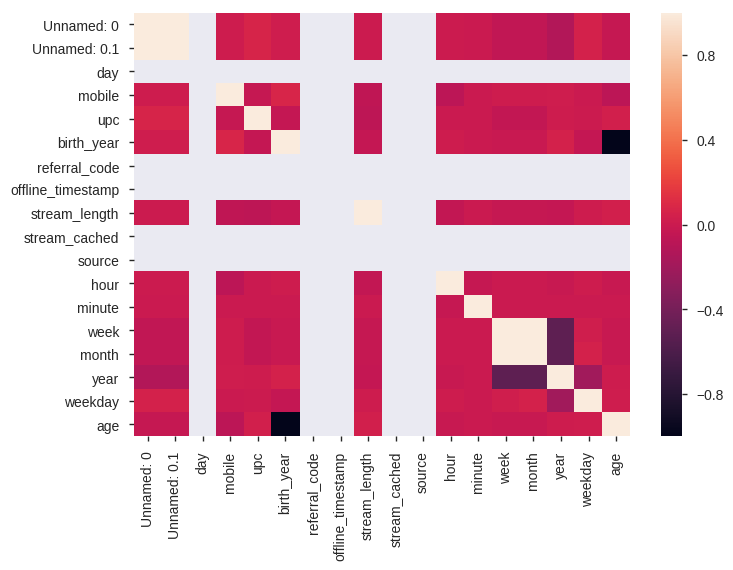

In [14]:
# Correlation matrix and heatmap
# Generate correlations for original data
corr = data.corr()
# Create a heatmap
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Those data fields that are highly correlated, before preprocessing, are where the juxtaposition is white or black
In particular the fields that are highly correlated are:
* Day to everything else
* Referral code to everything else
* offline timestamp to everything else
* Stream cached to everything else

Atfer removing all of the above fields the heatmap is now a bit cleaner.

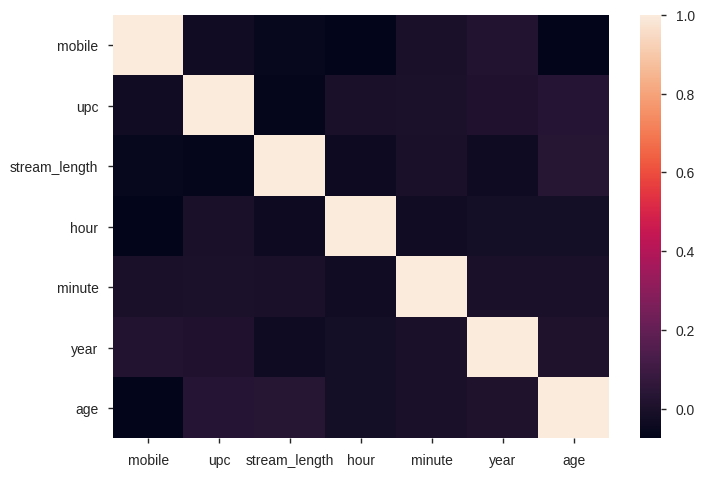

In [15]:
dat = data.drop(labels = ["Unnamed: 0","Unnamed: 0.1","day", "referral_code","offline_timestamp", "source", "stream_cached", 'birth_year', 'week', 'month', 'weekday'], axis=1)
corr = dat.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Correlation coefficients raw values

In [16]:
c = dat.corr().abs()
s = c.unstack()
so = s.sort_values(ascending=False)
print (so[14:])

stream_length  mobile           0.054684
hour           stream_length    0.038621
stream_length  hour             0.038621
               year             0.036053
year           stream_length    0.036053
age            stream_length    0.035854
stream_length  age              0.035854
upc            age              0.033179
age            upc              0.033179
mobile         upc              0.027254
upc            mobile           0.027254
hour           minute           0.026255
minute         hour             0.026255
mobile         year             0.023597
year           mobile           0.023597
               hour             0.017424
hour           year             0.017424
               age              0.016892
age            hour             0.016892
upc            year             0.013922
year           upc              0.013922
               age              0.009056
age            year             0.009056
hour           upc              0.004085
upc            h

## Time of the day by day heatmap

The heatmap shows:
* a low number of streams between midnight and 6 am in the morning,
* with the highest number of streams between 2 pm and 6 pm. 
* Sunday, Thursdays and Tuesdays are the days with the lowest streaming activity throughout the whole day.  
* Saturday afternoon has the longest span of time with the highest streaming activity.

The fact that Sunday is a low streaming activity day, is surprising - (perhaps another heatmap for Sunday by age and sex if we are interested and have time?)

Text(0.5,1,'Stream count by weekday and hour of day')

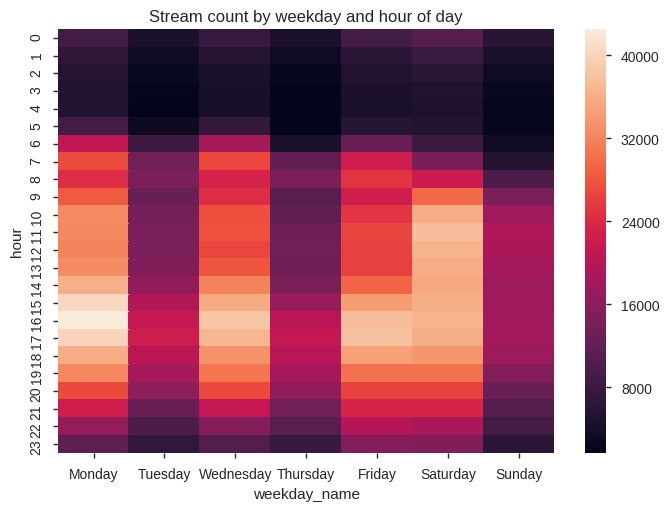

In [17]:
# Generate a plot of streaming frequency over day of week and time of day.
# Get a slice of the data we need
dfhourday = data[['hour', 'weekday_name']].copy()
# Categorize and sort by day
dfhourday['weekday_name'] = pd.Categorical(dfhourday['weekday_name'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
hour_by_day = dfhourday.sort_values(['weekday_name', 'hour'], ascending = [True, False])
# Visualize
vis_hour_by_day = (hour_by_day.groupby(['hour' , 'weekday_name'])).size().unstack().fillna(0)
sns.heatmap(vis_hour_by_day).set_title('Stream count by weekday and hour of day')

<div class="alert alert-warning">
<b>ACTION: Dependant variable </b> 

<p> Set up the problem as one of classification, selecting the relevant playlists as the variable we are trying to model.</p>

<p> Write useful helper functions to support creating of the feature vector and target vector </p>


</div>

# Defining the dependent variable

The success of an artist is defined on whether they have a song on one or all of the following playlists:

* Hot Hits UK
* Massive Dance Hits
* The Indie List 
* New Music Friday


Two columns are added to the dataset:
Artists are identified as:
* successful(1) or not successful(0);
* and the subset of successful artists prior to 2017.

In [18]:
# 4 key Playlists
#data['playlist_name'] = data.playlist_id.map(playlist_mapper.drop_duplicates(['id']).set_index('id')['name'])
spotfunc_v2.map_playlist_names(data, 'stream_source_uri', playlist_mapper)
key_playlists_names=['Hot Hits UK', 'Massive Dance Hits', 'The Indie List', 'New Music Friday']

# select relevant playlists 
key_playlists = data.dropna(subset=['playlist_id'])
key_playlists = key_playlists[key_playlists.playlist_name.isin(key_playlists_names)]
key_playlists_before_2017 = key_playlists[key_playlists['year']<2017]

# Define Dependent Variable
artists = data.artist_name.unique()

successful_artists = set(key_playlists.artist_name)
successful_artists_before_2017 = set(key_playlists_before_2017.artist_name)

def successful(df, artist_name):
    if artist_name in successful_artists:
        success = 1
    else:
        success = 0
    return success

def successful_before_2017(df, artist_name):
    if artist_name in successful_artists_before_2017:
        success = 1
    else:
        success = 0
    return success

# def get_successful_before (data):
df_bef = spotfunc_v2.subset_before_success(data, key_playlists, playlist_mapper)
data = df_bef['ndf']

Successful playlists in 2017:
          playlist_name             playlist_id  year  COUNT
1     New Music Friday  0dLTdpGyfO0PSyYXInvRd5  2017      1
2       The Indie List  37i9dQZF1DWVTKDs2aOkxu  2017    533
3          Hot Hits UK  37i9dQZF1DWY4lFlS4Pnso  2017  38150
4     New Music Friday  37i9dQZF1DX4JAvHpjipBk  2017    363
5   Massive Dance Hits  37i9dQZF1DX5uokaTN4FTR  2017   4131
6     New Music Friday  6wx0wiD9V6JJ2EOh4KM3Ox  2017      1
7     New Music Friday  1EnTBEgCWiTX2YHyAzkcFn  2017      2
10         Hot Hits UK  6FfOZSAN3N6u7v81uS7mxZ  2017  19992
12    New Music Friday  3DL9G1ApvJDIR4IhWIJ8AQ  2017      4
Successful playlists before 2017:
        playlist_name             playlist_id  year  COUNT
0   New Music Friday  0dLTdpGyfO0PSyYXInvRd5  2016      4
8        Hot Hits UK  6FfOZSAN3N6u7v81uS7mxZ  2015   6320
9        Hot Hits UK  6FfOZSAN3N6u7v81uS7mxZ  2016  86239
11  New Music Friday  3DL9G1ApvJDIR4IhWIJ8AQ  2016      2


## An illustration of exploratory analysis on the key playlists

* Is gender audience perhaps a good feature / predictor of artists' success? 

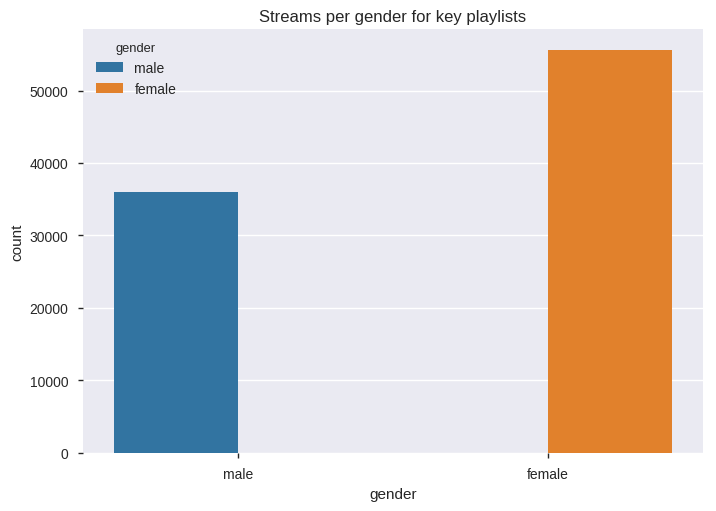

In [19]:
# top_playlist_streams per gender
top_streams_gender = pd.DataFrame(data[data['playlist_id'].isin(key_playlists.playlist_id)])
ax = sns.countplot(x= 'gender', hue='gender', data=top_streams_gender).set_title('Streams per gender for key playlists')

# FEATURES

<div class="alert alert-warning">
<b>ACTION: Artist features </b> 

<p> Write useful functions to create these new features. </p>


</div>

# Artist Features:
* Stream count;
* Number of users per artist;
* Passion score;
* Country of origin;
* Genre.

In [20]:
# Stream count per artist
def stream_count(df):
    stream_count = len(df)
    return stream_count

In [21]:
# Number of users per artist
def users_per_artist(df):
    users_per_artist = len(df.customer_id.unique())
    return users_per_artist

In [22]:
# Passion Score
def passion_score(df):
    if len(df.customer_id.unique()) == 0:
        passion_score = 0
    else:
        passion_score = round(len(df)/len(df.customer_id.unique()),2)
    return passion_score

In [23]:
# Country of origin
def coo(df, artist_name):
    coo = new_artists[new_artists.cleaned_names.str.contains(artist_name)].COUNTRY_OF_ORIGIN_CODE.unique().tolist()
    import math
    coo = [x for x in coo if str(x) != 'nan']
    return coo

In [24]:
# Genre
def genre(df, artist_name):
    genre = new_artists[new_artists.cleaned_names.str.contains(artist_name)].MAJOR_GENRE_CODE.unique().tolist()
    genre = [x for x in genre if str(x) != 'nan']
    return genre

<div class="alert alert-warning">
<b>ACTION: Playlist features </b> 

<p> Write useful functions to create new playlist features, like those listed in the cell above. </p>

<p> Are there other sensible ones you could suggest, work in your group to think about what other features might be useful and whether you can calculate them with the data you have </p>

</div>

# Playlist Features (for each artist)
* Average streams for a playlist (among top 20 playlists specific to each artist)
* Average unique users for each artist (among top 20 playlists specific to each artist)
* Average playlist passion score (among top 20 playlists specific to each artist)

In [25]:
# Avg stream count for 20 top playlists
def playlist_count(df):
    dfn= df.dropna(subset = ['playlist_name'])
    dfn = dfn.drop(dfn[dfn.playlist_name.isin(key_playlists_names)].index)
    playlist_stream_count = dfn.playlist_id.value_counts().head(20)
    avg = round(playlist_stream_count.mean(), 2)
    return avg

In [26]:
# Avg unique users for each artist on top 20 playlists
def playlist_users(df):
    dfn= df.dropna(subset = ['playlist_name'])
    dfn = dfn.drop(dfn[dfn.playlist_name.isin(key_playlists_names)].index)
    playlist_stream_count = dfn.playlist_id.value_counts().head(20).to_frame().reset_index()
    playlist_stream_count.columns = ['playlist_id', 'count']
    top20_playlists = dfn[dfn['playlist_id'].isin(playlist_stream_count.playlist_id)]
    avg = round(top20_playlists.groupby("playlist_id")["customer_id"].nunique().mean(), 2)
    return avg

In [27]:
#def playlist_avg_passion_score(data):
def playlist_passion_score(df):
    dfn= df.dropna(subset = ['playlist_name'])
    dfn = dfn.drop(dfn[dfn.playlist_name.isin(key_playlists_names)].index)
    playlist_stream_count = dfn.playlist_id.value_counts().head(20)
    stream_count = round(playlist_stream_count.mean(), 2)
    dfn2= df.dropna(subset = ['playlist_name'])
    dfn2 = dfn2.drop(dfn2[dfn2.playlist_name.isin(key_playlists_names)].index)
    playlist_stream_count = dfn2.playlist_id.value_counts().head(20).to_frame().reset_index()
    playlist_stream_count.columns = ['playlist_id', 'count']
    top20_playlists = dfn[dfn['playlist_id'].isin(playlist_stream_count.playlist_id)]
    user_count = round(top20_playlists.groupby("playlist_id")["customer_id"].nunique().mean(), 2)
    playlist_avg_passion_score = stream_count / user_count
    return playlist_avg_passion_score

## User-base features

<div class="alert alert-warning">
<b>ACTION: User features </b> 

<p> Write useful functions to create new user features, like those listed in the cell above. </p>

<p> Are there other sensible ones you could suggest? Work in your group to think about what other features might be useful and whether you can calculate them with the data you have. Justify your reasoning. </p>

</div>

# User Features
* Gender breakdown;
* Age breakdown by bands:
    * 0-18
    * 19-25
    * 26-50
    * 51-100

In [28]:
# Gender breakdown
male_perc = round(spotfunc_v2.gender_percentage(data), 2)
female_perc = round(1-male_perc,2)
print('Percentage of males: ', male_perc)
print('Percentage of females: ', female_perc)

Percentage of males:  0.46
Percentage of females:  0.54


In [29]:
# Age breakdown (Age vector quantization)
age_percentages = spotfunc_v2.age_percentages(data)
age_percentages

{'0-18': 0.2, '19-25': 0.4, '26-50': 0.37, '51-100': 0.03}

<div class="alert alert-warning">
<b>ACTION: PCA features </b> 

<p> Write useful functions to create new user feature based on regions data. </p>

<p> Are there other sensible features you could suggest? Work in your group to think about what other features might be useful and whether you can calculate them with the data you have. Justify your reasoning. </p>

</div>

## Generate PCA Function
The generate PCA function receives a dataframe create a PCA with a parameters for a PCA

In [30]:
def generate_pca(plot_legend, df, row_col, component_col, binary = False, pca_n_comp=10, orig_comp_head = 1000, scale_data=False):
    def dropna_splitdf(df,split_size):
        split_df = np.array_split(df, split_size)
        for i in split_df:
            i = i.dropna(subset=[component_col])
        return pd.concat(split_df)
    split_df = True
    if split_df:
        df = dropna_splitdf(df,4)
    else:
        df = df.dropna(subset=[component_col])
    subset = df[df[component_col].isin(df[component_col].value_counts().head(orig_comp_head).index)]
    pca_df = subset.groupby([row_col,component_col]).size().unstack(fill_value=0)
    ind = pca_df.index
    component_names = pca_df.columns
    if binary ==True:
        pca_df[pca_df>0]= 1
    if scale_data & binary == False:
        pca_df = pd.DataFrame(scale(pca_df))
    pca_df_sparsity = np.count_nonzero(pca_df)/len(pca_df.values.flatten())
    X = pca_df
    pca = decomposition.PCA()
    pca.fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), label = plot_legend)
    plt.xlabel('number of components')
    plt.legend()
    plt.ylabel('cumulative explained variance');
    decomposition.PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
      svd_solver='auto', tol=0.0, whiten=False)
    pca.n_components = pca_n_comp
    X_reduced = pca.fit_transform(X)
    var_exp_cumsum = pca.explained_variance_ratio_.cumsum()
    var_exp_ratio = pca.explained_variance_ratio_
    var_exp = pca.explained_variance_
    mean = pca.mean_
    components =pca.components_
    pca_final = pd.DataFrame(X_reduced, index=ind)
    pca_final.columns = ['PCA_'+component_col+'_'+str(x+1).format(component_col) for x in pca_final.columns]
    output = {'pca_df_sparisity':pca_df_sparsity,
              #'pca_df':pca_df, # DF to be inputed to PCA ??????????????????
              'var_exp_cumsum':var_exp_cumsum,
              'pca_output_df':pca_final,
              'var_exp_ratio':var_exp_ratio,
              'var_exp':var_exp,
              'mean':mean,
              'components':components,
              'component_names': component_names
             }
    return output

## PCA Generated

The following pca were generated from the following data:
    * Artist streams be region;
    * Artist streams per playlist id;
    * Artist streams per customer id;
    * Artist streams per isrc.

<div class="alert alert-warning">
<b>ACTION: PCA plot </b> 

<p> Use a figure to show which components of PCA explain the majority of variation in the data. Accordingly, use only those components in your further analysis.</p>

</div>

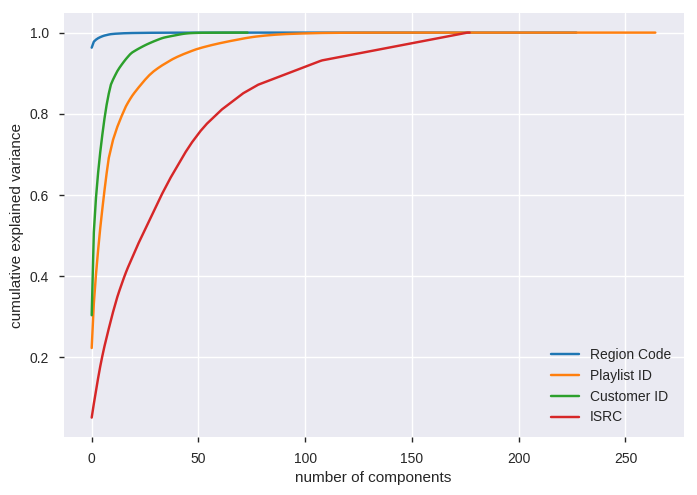

In [31]:
# Run PCA for 'region_code' by 'artist_name'
reg_pca = generate_pca('Region Code', data, 'artist_name', 'region_code', binary = False, pca_n_comp=10, orig_comp_head = 1000, scale_data=False)

# Run PCA for 'playlist_id' by 'artist name'
playlist_pca = generate_pca('Playlist ID', data, 'artist_name', 'playlist_id', binary = False, pca_n_comp=10, orig_comp_head = 1000, scale_data=False)

# Run PCA for 'customer_id' by 'artist name'
customer_pca = generate_pca('Customer ID', data, 'artist_name', 'customer_id', binary = False, pca_n_comp=50, orig_comp_head = 1000, scale_data=False)

# Run PCA for 'isrc' by 'artist_name'
isrc_pca = generate_pca('ISRC', data, 'artist_name', 'isrc', binary = False, pca_n_comp=10, orig_comp_head = 1000, scale_data=False)

In [32]:
print('Cummulative sum of explained variance by ISRC components n=10 : ', isrc_pca['var_exp_cumsum'])
print('Cummulative sum of explained variance by regional_code components n=10 : ', reg_pca['var_exp_cumsum'])
print('Cummulative sum of explained variance by playlist components n=10 : ', playlist_pca['var_exp_cumsum'])
print('Cummulative sum of explained variance by customer ID components n=50 : ', customer_pca['var_exp_cumsum'])

Cummulative sum of explained variance by ISRC components n=10 :  [0.0510391  0.08509418 0.11714682 0.14816811 0.17718999 0.2032205
 0.22725045 0.24928815 0.27038989 0.2913226 ]
Cummulative sum of explained variance by regional_code components n=10 :  [0.9628779  0.97765403 0.98262332 0.9861725  0.98879994 0.99100061
 0.99275367 0.99406917 0.99523363 0.99618558]
Cummulative sum of explained variance by playlist components n=10 :  [0.22255178 0.33200751 0.40347641 0.46348048 0.51807385 0.56608091
 0.61147538 0.65346694 0.69092627 0.71358319]
Cummulative sum of explained variance by customer ID components n=50 :  [0.30336695 0.5080826  0.5924491  0.65433884 0.70527416 0.74906487
 0.78851214 0.82218587 0.84960984 0.87196139 0.88420112 0.89483605
 0.90496424 0.91331139 0.92074802 0.92780715 0.93459077 0.94074828
 0.94666127 0.95112333 0.95437788 0.95750798 0.96051412 0.96334461
 0.96614337 0.96880309 0.97133094 0.97369026 0.97598514 0.97825273
 0.980361   0.98244492 0.98448683 0.98631823 0.

## PCA output

* ISRC components explain only a small fraction of the variance, hence ISRC was dropped altogether as a feature
* Similarly playlists were dropped too. Only the original playlists features were retained as features. 
* Regional results are really promising. We will keep the top 5 components only as they cummulatively explain more than enough variance.
* For customer IDs we retained the first 20 components to reach at least 0.95.

# Building the Feature Set:
The feature set code was built to provide an easy way to add and remove features from the feature set for the models.  The set of features passed into the models are:

* Country of origin of the artist;
* Genre of the artist;
* Stream count for the artist;
* Unique users for the artist;
* The passion score for the artist;
* Gender percentages of the users for the artist;
* PCA components for the artist streams per region code;
* PCA components for the unique customers per artist;

This feature set are generated and passed to a dict named 'output_all' for each art.  The final data frame for all artist were generated.

In [33]:
features = [ 'coo', 
             'genre',
             #'successful',
             #'successful_before_2017',
             'stream_count',
             'users_per_artist',
             'passion_score',
             'gender_percentage',
             '0-18', '19-25', '26-50', '51-100', 
             'playlist_count',
             'playlist_users',
             'playlist_passion_score',
             # region_codes
             'PCA_region_code_1', 'PCA_region_code_2', 'PCA_region_code_3', 'PCA_region_code_4', 'PCA_region_code_5',
             #'PCA_region_code_6', 'PCA_region_code_7', 'PCA_region_code_8', 'PCA_region_code_9', 'PCA_region_code_10',
             # customer_ids
             'PCA_customer_id_1', 'PCA_customer_id_2', 'PCA_customer_id_3', 'PCA_customer_id_4', 'PCA_customer_id_5',
             'PCA_customer_id_6', 'PCA_customer_id_7', 'PCA_customer_id_8', 'PCA_customer_id_9', 'PCA_customer_id_10',
             'PCA_customer_id_11', 'PCA_customer_id_12', 'PCA_customer_id_13', 'PCA_customer_id_14', 'PCA_customer_id_15',
             'PCA_customer_id_16', 'PCA_customer_id_17', 'PCA_customer_id_18', 'PCA_customer_id_19', 'PCA_customer_id_20'
             #'PCA_customer_id_21', 'PCA_customer_id_22', 'PCA_customer_id_23', 'PCA_customer_id_24', 'PCA_customer_id_25',
             #'PCA_customer_id_26', 'PCA_customer_id_27', 'PCA_customer_id_28', 'PCA_customer_id_29', 'PCA_customer_id_30',
             #'PCA_customer_id_31', 'PCA_customer_id_32', 'PCA_customer_id_33', 'PCA_customer_id_34', 'PCA_customer_id_35',
             #'PCA_customer_id_36', 'PCA_customer_id_37', 'PCA_customer_id_38', 'PCA_customer_id_39', 'PCA_customer_id_40',
             #'PCA_customer_id_41', 'PCA_customer_id_42', 'PCA_customer_id_43', 'PCA_customer_id_44', 'PCA_customer_id_45',
             #'PCA_customer_id_46', 'PCA_customer_id_47', 'PCA_customer_id_48', 'PCA_customer_id_49', 'PCA_customer_id_50',
             # playlist_ids
             #'PCA_playlist_id_1', 'PCA_playlist_id_2', 'PCA_playlist_id_3', 'PCA_playlist_id_4', 'PCA_playlist_id_5',
             #'PCA_playlist_id_6', 'PCA_playlist_id_7', 'PCA_playlist_id_8', 'PCA_playlist_id_9', 'PCA_playlist_id_10'
            ]

# Aggregate feature creation functions
def create_artist_features(df, artist_name):
    success = successful(df, artist_name)
    success_before_2017 = successful_before_2017(df, artist_name)
    stream_ct = stream_count(df)
    users_per_art = users_per_artist(df)
    passion_sc = passion_score(df)
    gender_per = spotfunc_v2.gender_percentage(df)
    age_per = spotfunc_v2.age_percentages(df)
    #day = day_num(df)
    origin = coo(df, artist_name)
    gen = genre(df, artist_name)
    playlist_avg_stream_count = playlist_count(df)
    playlist_avg_user_count = playlist_users(df)
    playlist_avg_passion_score = playlist_passion_score(df)
    return {
        'successful': success,
        'successful_before_2017': success_before_2017,
        'stream_count': stream_ct,
        'users_per_artist': users_per_art,
        'passion_score': passion_sc,
        'gender_percentage': gender_per,
        'age_percentages': age_per,
        'coo': origin,
        'genre': gen,
        'playlist_count': playlist_avg_stream_count,
        'playlist_users': playlist_avg_user_count,
        'playlist_passion_score': playlist_avg_passion_score
    }

# Loop through all artists and generate features
output_all = {artist: create_artist_features(data[data['artist_name']==artist], str(artist)) for artist in artists}

# Filter to remove artists with no data
missing_data = [x for x in output_all.keys() if len(output_all[x]) == 0]
filter_output_all = {x:output_all[x] for x in output_all.keys() if len(output_all[x])>0}

# Generate final dataframe
#final_df = (pd.DataFrame(filter_output_all).transpose()
final_df = (pd.DataFrame(output_all).transpose()
.merge(reg_pca['pca_output_df'], how='left', left_index= True, right_index=True)
.merge(playlist_pca['pca_output_df'], how='left', left_index= True, right_index=True)
.merge(customer_pca['pca_output_df'], how='left', left_index= True, right_index=True)
.merge(isrc_pca['pca_output_df'], how='left', left_index= True, right_index=True))
final_df['0-18'] = final_df.age_percentages.apply(lambda x: x['0-18'])
final_df['19-25'] = final_df.age_percentages.apply(lambda x: x['19-25'])
final_df['26-50'] = final_df.age_percentages.apply(lambda x: x['26-50'])
final_df['51-100'] = final_df.age_percentages.apply(lambda x: x['51-100'])
final_df = final_df.drop(['age_percentages'], axis = 1)
size_old = len(final_df)

## Inspecting final DF output

In [34]:
final_df.head(10)

,coo,gender_percentage,genre,passion_score,playlist_count,playlist_passion_score,playlist_users,stream_count,successful,successful_before_2017,...,PCA_isrc_5,PCA_isrc_6,PCA_isrc_7,PCA_isrc_8,PCA_isrc_9,PCA_isrc_10,0-18,19-25,26-50,51-100
17 memphis,[UNITED STATES],0,[Country],0,NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2d,[INDONESIA],0,[J-Pop],0,NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3js,[NETHERLANDS],0.75,[Pop],1.25,NaN,NaN,NaN,5,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.25,0.75,0.00
90s update,[GERMANY],0,[Pop],0,NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99 percent,[UNITED STATES],0.318132,"[Rap/Hip Hop, Hip Hop]",1.08,2.85,1,2.85,999,0,0,...,-0.374638,-0.327586,-0.311972,-0.254872,-0.015450,-0.399461,0.40,0.32,0.25,0.03
a boogie wit da hoodie,[UNITED STATES],0.744032,[Rap/Hip Hop],1.23,96.5,1.06219,90.85,4628,1,0,...,-1.022991,-1.167562,-1.384380,-1.718154,-0.808865,-3.967389,0.24,0.49,0.26,0.01
a r i z o n a,[UNITED STATES],0.501286,"[Alternative, Dance]",1.09,396.15,1.03379,383.2,15681,1,0,...,-0.568502,-0.562109,-0.539396,-0.381377,-0.224944,-0.512556,0.13,0.43,0.41,0.04
absofacto,[UNITED STATES],0,[Pop],0,NaN,NaN,NaN,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adan carmona,[SPAIN],0.25,[Dance],1,1,1,1,8,0,0,...,-0.361170,-0.314350,-0.298287,-0.242815,-0.014281,-0.379518,0.00,0.38,0.62,0.00
adia victoria,[UNITED STATES],0.647841,[Alternative],1.13,19.64,1.0192,19.27,340,0,0,...,-0.576650,-0.524928,-0.536494,-0.529363,-0.368176,-0.668506,0.05,0.24,0.63,0.07


## Clean up the feature set by:
* Convert country of origin and genre to strings;
* Drop artists were a NaN exists for a features

In [35]:
# Convert coo and genre to str
final_df['coo'] = final_df.coo.map(str)
final_df['genre'] = final_df.genre.map(str)

# Drop nan's
final_df = final_df.dropna(subset = ['coo'])
size_new = len(final_df)
final_df = final_df.dropna(subset = ['genre'])
size_new2 = len(final_df)
drop_coo = size_old - size_new
drop_genre = size_new - size_new2
print('Dropped artists because of NaN COO: ', drop_coo)
print('Dropped artists because of NaN Genre: ', drop_genre)

# Drop successful artists pre 2017
final_df = final_df[final_df.successful_before_2017 == 0]

Dropped artists because of NaN COO:  0
Dropped artists because of NaN Genre:  0


## Collect all the genres assigned to artists.

In [36]:
all_genres=[]
for i in final_df.genre:
    for j in i:
        if j not in all_genres:
            all_genres.append(j)
print('Number of different genres: ', len(all_genres))

Number of different genres:  45


## Collect all the countries of origin assigned to artists

In [37]:
all_coo=[]
for i in final_df.coo:
    for j in i:
        if j not in all_coo:
            all_coo.append(j)
print('Number of different countries of origin of artists: ', len(all_coo))

Number of different countries of origin of artists:  30


Given the not-so large number of unique genres & countries it was decided not to perform additional PCA to reduce the dimensionality of these features too. Instead label encoding was used.

<div class="alert alert-warning">
<b>ACTION: Missing values </b> 

<p> Use the **`Imputer`** class to alter your final Dataframe that contains your feature vector.</p>

</div>

## Remove missing values from the feature set.
The median values if the type of variable is integer or float. 
Otherwise fill the value with zero.

In [38]:
# Handle missing values
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

for i in final_df.columns:
        if final_df[i].dtype == 'int64' or final_df[i].dtype == 'float64':
            final_df[i] = imp.fit_transform(final_df[[i]])
            
#fill remaining nan with 0
final_df = final_df.fillna(0)

<div class="alert alert-warning">
<b>ACTION: Feature transformation </b> 

<p> Comment on whether transforming particular features (influence, gender breakdown, age breakdown) is useful. Calculate the transformation where necessary.</p>

</div>

## Standardize numeric variables

* This is a requirement for performing logistic regression
* But also helpful for all variables were relative differences are more informative than absolute differences

In [39]:
# Data scaling
from sklearn.preprocessing import StandardScaler
scale_variables = ['passion_score', 'playlist_users', 'playlist_passion_score', 'gender_percentage', '0-18', '19-25', '26-50']
for i in scale_variables:
    final_df[i] = final_df[i].astype(float)
    scaler = StandardScaler()
    final_df[[i]] = scaler.fit_transform(final_df[[i]])

## Encode:
* the country of origin and;
* genre of the artist.

This is done because none of the classification models accept categorical variables as input. As such all categorical variables need to converted to a numeric encoded version.

In [40]:
# Label encode categorical variables
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

for i in final_df.columns:
    if i in ['coo','genre'] :
        final_df[i] = label_encoder.fit_transform(final_df[i].map(str))

<div class="alert alert-warning">
<b>ACTION: Multi-collinearity </b> 

<p> Check and deal with multi-collinearity in your feature set.</p>

</div>

## Find collinearity within the feature set

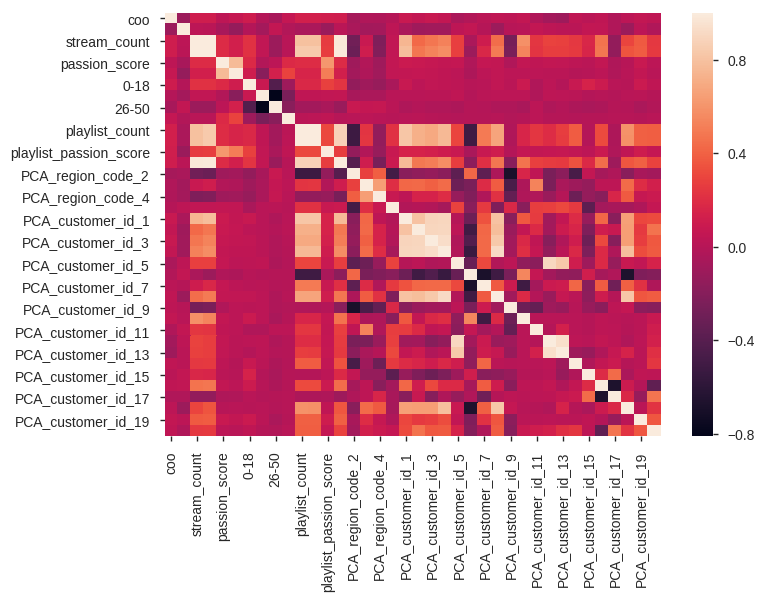

In [41]:
# Check for multicollinearity only on the features of interest inside final_df
data_corr = final_df[features]

# Generate correlation coefficients
corr = spotfunc_v2.generate_correlations(data_corr)
corr_all = data_corr.corr()

# Draw heatmap
sns.heatmap(corr_all)

## Raw values

In [42]:
c = data_corr.corr().abs()
s = c.unstack()
so = s.sort_values(ascending=False)
print (so[37:])

coo                 coo                   1.000000
playlist_users      playlist_count        0.999924
playlist_count      playlist_users        0.999924
stream_count        users_per_artist      0.996380
users_per_artist    stream_count          0.996380
PCA_region_code_1   users_per_artist      0.987018
users_per_artist    PCA_region_code_1     0.987018
PCA_region_code_1   stream_count          0.980207
stream_count        PCA_region_code_1     0.980207
PCA_customer_id_13  PCA_customer_id_12    0.942049
PCA_customer_id_12  PCA_customer_id_13    0.942049
PCA_customer_id_3   PCA_customer_id_4     0.930131
PCA_customer_id_4   PCA_customer_id_3     0.930131
PCA_customer_id_8   PCA_customer_id_4     0.915611
PCA_customer_id_4   PCA_customer_id_8     0.915611
PCA_customer_id_5   PCA_customer_id_12    0.905255
PCA_customer_id_12  PCA_customer_id_5     0.905255
PCA_customer_id_2   PCA_customer_id_4     0.901189
PCA_customer_id_4   PCA_customer_id_2     0.901189
PCA_customer_id_2   PCA_custome

The following highly correlated features are removed:
    * Age range 51-100;
    * Stream count per artist;
    * Playlist count per artist;
    * Users per artist;
    * PCA component No. 3 and 4 for the customer id per artist.

## Threshold was set at 0.82

In [43]:
# Removing highly correlated varibles
corr_vars = ['51-100', 'stream_count', 'playlist_count',  'playlist_users', 'users_per_artist', 'PCA_customer_id_3', 'PCA_customer_id_4', 'PCA_customer_id_4', 'PCA_customer_id_11']

# Rest features list to be passed on as an argument later on 
features = list(set(features) - set(corr_vars))

# Update the final_df
final_df = final_df.drop(corr_vars, 1)

## Checking again 

In [44]:
data_corr = final_df[features]

# Generate correlation coefficients
corr = spotfunc_v2.generate_correlations(data_corr)
corr_all = data_corr.corr()

c = data_corr.corr().abs()
s = c.unstack()
so = s.sort_values(ascending=False)
print (so[31:])

PCA_customer_id_12  PCA_customer_id_13    0.942049
                    PCA_customer_id_5     0.905255
PCA_customer_id_5   PCA_customer_id_12    0.905255
PCA_customer_id_13  PCA_customer_id_5     0.830631
PCA_customer_id_5   PCA_customer_id_13    0.830631
PCA_customer_id_18  PCA_customer_id_8     0.826176
PCA_customer_id_8   PCA_customer_id_18    0.826176
19-25               26-50                 0.811796
26-50               19-25                 0.811796
PCA_customer_id_2   PCA_customer_id_1     0.805778
PCA_customer_id_1   PCA_customer_id_2     0.805778
                    PCA_customer_id_8     0.804483
PCA_customer_id_8   PCA_customer_id_1     0.804483
                    PCA_customer_id_2     0.787316
PCA_customer_id_2   PCA_customer_id_8     0.787316
PCA_region_code_1   PCA_customer_id_1     0.771697
PCA_customer_id_1   PCA_region_code_1     0.771697
gender_percentage   passion_score         0.771134
passion_score       gender_percentage     0.771134
PCA_customer_id_9   PCA_region_

<div class="alert alert-warning">
<b>ACTION: Class balance </b> 

<p> Calculate and comment on class balance.</p>

</div>

## Calculate Class Balance between successful and non-successful artists

In [45]:
# Class balance
class_balance = final_df.successful.value_counts()[0]/final_df.successful.value_counts().sum()*100
print('Class balance (unsuccessful artists) = ', (round(class_balance,2)))
print('Rows:',len(final_df.index))

Class balance (unsuccessful artists) =  92.18
Rows: 422


## Re-balance to 60/40

In [46]:
# Unbias - sample from unsuccessful class for 60/40 split (1.5:1 = 60/40)

np.random.seed(42)

p1 = final_df[final_df.successful == True]
p2 = final_df[final_df.successful == False].sample(round(len(p1)*1.5), random_state=5)
p3 = pd.concat([p1,p2])
final_df2 = p3[:]
class_balance = final_df2.successful.value_counts()[0]/final_df2.successful.value_counts().sum()*100
print('Class balance (unsuccessful artists) = ', (round(class_balance,2)))
print('Rows:',len(final_df2.index))
print('Success cases: ', final_df2.successful.value_counts()[0])
print('No-success cases: ', final_df2.successful.value_counts()[1])

Class balance (unsuccessful artists) =  60.24
Rows: 83
Success cases:  50
No-success cases:  33


## Model Selection

<div class="alert alert-warning">
<b>ACTION: Spot-check algorithms </b> 

<p> Try a mixture of algorithm representations (e.g. instances and trees). </p>

<p> Try a mixture of learning algorithms (e.g. different algorithms for learning the same type of representation).<p>

<p> Try a mixture of modeling types (e.g. linear and nonlinear functions or parametric and nonparametric).</p>

<p> Divide this work up among the different members of your team and then compare and comment on the performance of various approaches.</p>

</div>

In [47]:
# Split into train and validation set
from sklearn.model_selection import train_test_split
X = final_df2[features].values
y = final_df2['successful'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
output =  {'X':X,'y':y,'X_train':X_train,'X_test':X_test, 'y_train':y_train, 'y_test':y_test, 'corr':corr, 
'final_df':final_df2, 'features':features,'class_balance':class_balance}

We experimented with various splits:
* 80/20
* 70/30
* 60/40

A 70/30 split gave us the best results, with 80/20 a close second. Given the slightly higher lift and the bigger abundance of test cases we opted for the 70/30 split.

Below we have created all the models that we intended to test in the first stage of the algorithms evaluation. We have selected the following models:
*	Logistic Regression (LR)
*	Decision Tree (DT)
*	Random Forest (RF)
*	Linear Discriminant Analysis (LDA)
*	Support Vector Classifier (SVM)
*	AdaBoost (ADB)
*	XGBoost (XGB)
 
We have fit the training data for each of the models and run prediction for test data.

For each of the above mentioned models we have presented the accuracy scores, before running cross validatation. Additionally we have run 10 fold cross validation for each of the models and provided the mean and standard deviation (in brackets) for the cross validated scores. We can see that the models are not very stable and present significant differences among cross validated results. It is also clear from the Algorithm comparison graph that the scope of accuracies is quite broad among the evaluated models. In the later part of the notebook we will increase the accuracy of the results.

The top 3 most accurate models are: **Gaussian Naive Bayes**, **Logistic Regression**, and **AdaBoost**.

We have also tried different parameters for the models, i.e. tried entropy and gini criterion for Decision Tree, different numbers of estimations for Random Fores, etc. However, we decided to leave the paramters as defualt in this section so we can compare the results of the models and see which ones seem to be the most promising. Eventually we agreed that we will run Grid Search on the selected models so we can get the optimal parameters.


In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as pyplot
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

#Logsitic Regression
LR_model = LogisticRegression(random_state=42)
LR_model.fit(X_train, y_train)
y_pred_LR = LR_model.predict(X_test)
predictions_LR = [round(value) for value in y_pred_LR]
LR_accuracy = accuracy_score(y_test, predictions_LR)
print("LR Accuracy: %.2f%%" % (LR_accuracy * 100.0))

#DECISION TREE
DT_model = DecisionTreeClassifier(random_state=42)
DT_model.fit(X_train, y_train)
y_pred_DT = DT_model.predict(X_test)
predictions_DT = [round(value) for value in y_pred_DT]
DT_accuracy = accuracy_score(y_test, predictions_DT)
print("DT Accuracy: %.2f%%" % (DT_accuracy * 100.0))

#Random Forest
RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X_train, y_train)
y_pred_RF = RF_model.predict(X_test)
predictions_RF = [round(value) for value in y_pred_RF]
RF_accuracy = accuracy_score(y_test, predictions_RF)
print("RF Accuracy: %.2f%%" % (RF_accuracy * 100.0))

#LDA
LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, y_train)
y_pred_LDA = LDA_model.predict(X_test)
predictions_LDA = [round(value) for value in y_pred_LDA]
LDA_accuracy = accuracy_score(y_test, predictions_LDA)
print("LDA Accuracy: %.2f%%" % (LDA_accuracy * 100.0))

#SVC
SVC_model = SVC(random_state=42)
SVC_model.fit(X_train, y_train)
y_pred_SVC = SVC_model.predict(X_test)
predictions_SVC = [round(value) for value in y_pred_SVC]
SVC_accuracy = accuracy_score(y_test, predictions_SVC)
print("SVM Accuracy: %.2f%%" % (SVC_accuracy * 100.0))

#Gaussian NB
GNB_model = GaussianNB()
GNB_model.fit(X_train, y_train)
GaussianNB(priors=None)
y_pred_GNB = GNB_model.predict(X_test)
predictions_GNB = [round(value) for value in y_pred_GNB]
GNB_accuracy = accuracy_score(y_test, predictions_GNB)
print("GNB Accuracy: %.2f%%" % (GNB_accuracy * 100.0))

# XGBOOST
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
predictions_xgb = [round(value) for value in y_pred_xgb]
xgb_accuracy = accuracy_score(y_test, predictions_xgb)
print("XGB Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

# ADABOOST
adb_model = AdaBoostClassifier(random_state=42)
adb_model.fit(X_train, y_train)
y_pred_adb = adb_model.predict(X_test)
predictions_adb = [round(value) for value in y_pred_adb]
adb_accuracy = accuracy_score(y_test, predictions_adb)
print("ADB Accuracy: %.2f%%" % (adb_accuracy * 100.0))

# prepare models
models = []
models.append(('LR' , LogisticRegression(random_state=42)))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('DT' , DecisionTreeClassifier(random_state=42)))
models.append(('RF' , RandomForestClassifier(random_state=42)))
models.append(('NB' , GaussianNB()))
models.append(('ADB' , AdaBoostClassifier(random_state=42)))
models.append(('XGB' , XGBClassifier(random_state=42)))
models.append(('SVM' , SVC(random_state=42)))

# evaluate each model in turn
print('Cross Validated scores: ')

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR Accuracy: 76.00%
DT Accuracy: 60.00%
RF Accuracy: 80.00%
LDA Accuracy: 76.00%
SVM Accuracy: 68.00%
GNB Accuracy: 84.00%
XGB Accuracy: 68.00%
ADB Accuracy: 72.00%
Cross Validated scores: 
LR: 0.733333 (0.317980)
LDA: 0.450000 (0.365529)
DT: 0.600000 (0.280872)


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RF: 0.716667 (0.247768)
NB: 0.850000 (0.240947)
ADB: 0.616667 (0.307770)
XGB: 0.650000 (0.252212)
SVM: 0.500000 (0.394405)


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

## First model results
Whereas accuracies are not very high, we had a very limited time to come up with additional features or explore more collinearity between existing features and other potential avenues that we could explore to clean up more the incoming signal. Instead we opted to invest more time on tuning the models to perform better and create ensembles to leverage their collective power.

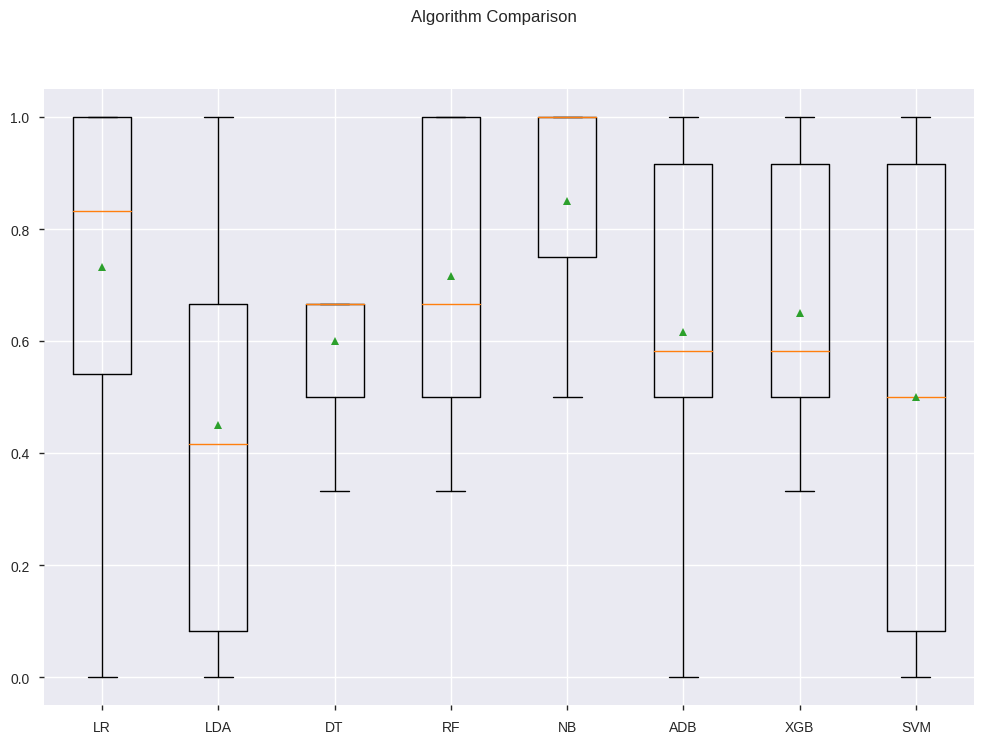

In [49]:
# boxplot algorithm comparison
fig = pyplot.figure(figsize=(12, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results, showmeans=True)
ax.set_xticklabels(names)
pyplot.show()

From the plot above we would have selected LR, NB, RF and XGB as our top 3 candidate models for further exploration. Unfortunately we mixed up our random seeds and had already selected models on a previous rendition where AdaBoost, NB, XGB and RF were outperforming the rest. Since we had already ran GridSearch and tuned the hyperparameters on those and were running out of time we chose to stick with this. 

If we had the oportunity to go back to this, we would have switched over to LR, NB, RF and XGB.

## Hyper Parameter Tuning - GridSearch

<div class="alert alert-warning">
<b>ACTION:  Hyper Parameter Tuning  </b> 

<p> Perform hyperparameter turing and demonstrate improved performance. Comment on any specific behaviour of your chosen classifier and set out the final structure and parameter settings.</p>

</div>

Given the restrictions of Gaussian Naive Bayes and Logistic Regression, we have decided to perform hyperparameters tuning on **AdaBoost**, **Random Forest**, and **XGBoost** models, as we believe that they offer the most promising improved results.

For **AdaBoost** classifier the parameters that we are testing include number of estimators and learning rate. For **Random Forest** classifier we are tuning the number of features to consider when looking for the best split and number od trees in the forest. For **XGBoost** classifier we are tuning maximum tree depth, number of boosted trees, and learning rate.

The improved accuracies as well as scores and confusion matrices are presented below each cell with the grid search. All the scores were cross validated - 10 folds. After tuning and selecting the best parameters we are fitting the new model with the new paramters, running the predictions, and testing accuracy.

Below each cell with the grid search, we present the following information:
* Best parameters of the model
* Mean of all cross validated results
* Accuracy of the tuned model 
* Confusion matrix

For each and every one of the tuned models the accuracy has significantly increased. 

The below imporoved models will be used to create an ensamble.

In [50]:
# SELECTED MODEL: ADB

# GRIDSEARCH
model = AdaBoostClassifier(random_state=42)
from sklearn.model_selection import GridSearchCV, cross_val_score
param_grid = {
    'n_estimators': [500, 1000, 1500, 3000],
    'learning_rate': [0.1, 0.5, 1]
}

CV_adb = GridSearchCV(estimator=model, param_grid=param_grid, cv= 10)
CV_adb.fit(X_train, y_train)

print('GRIDSEARCH - AdaBoost')
print('-'*10)
print('Best Parameters: ',CV_adb.best_params_)
print('Mean of Cross Validated Scores: ',CV_adb.best_score_)

# PRINT FINAL MODEL RESULT
finalmodel_ada = AdaBoostClassifier(n_estimators=CV_adb.best_params_['n_estimators'], learning_rate = CV_adb.best_params_['learning_rate'], random_state=42)
finalmodel_ada.fit(X_train,y_train)
    
# VALIDATION SET SCORE
from sklearn.metrics import confusion_matrix
y_pred = finalmodel_ada.predict(X_test)
train_score = finalmodel_ada.score(X_train, y_train)
validation_score_ada = accuracy_score(y_test, y_pred)
print('Accuracy of the tuned model: ', validation_score_ada)

GRIDSEARCH - AdaBoost
----------
Best Parameters:  {'learning_rate': 0.5, 'n_estimators': 3000}
Mean of Cross Validated Scores:  0.6896551724137931
Accuracy of the tuned model:  0.76


Comparing this accuracy with that of the model pre-tuning from above where:

ADB: 0.650000 

It is evident that grid search is properly chosing better hyperparameters to tune the model to.

In [51]:
# SELECTED MODEL: XGB

# GRIDSEARCH
model = XGBClassifier(random_state=42)
from sklearn.model_selection import GridSearchCV, cross_val_score
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.1, 0.5, 1]
}

CV_xgb = GridSearchCV(estimator=model, param_grid=param_grid, cv= 10)
CV_xgb.fit(X_train, y_train)

print('GRIDSEARCH')
print('-'*10)
print('Best Parameters: ',CV_xgb.best_params_)
print('Mean of Cross Validated Scores: ',CV_xgb.best_score_)

# PRINT FINAL MODEL RESULT
finalmodel_xgb = XGBClassifier(n_estimators=CV_xgb.best_params_['n_estimators'], max_depth=CV_xgb.best_params_['max_depth'], learning_rate = CV_xgb.best_params_['learning_rate'], random_state=42)
finalmodel_xgb.fit(X_train,y_train)
    
# VALIDATION SET SCORE
from sklearn.metrics import confusion_matrix
y_pred = finalmodel_xgb.predict(X_test)
train_score = finalmodel_xgb.score(X_train, y_train)
validation_score_xgb = accuracy_score(y_test, y_pred)
print('Accuracy of the tuned model: ', validation_score_xgb)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

GRIDSEARCH
----------
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Mean of Cross Validated Scores:  0.7068965517241379
Accuracy of the tuned model:  0.68


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

Comparing this accuracy with that of the model pre-tuning from above where:

XGB: 0.650000

It is evident that grid search is properly chosing better hyperparameters to tune the model to.

In [52]:
# SELECTED MODEL: Random Forest

# GRIDSEARCH
model = RandomForestClassifier(n_jobs=-1, oob_score = False, random_state=42)
from sklearn.model_selection import GridSearchCV, cross_val_score
param_grid = {
    'n_estimators': [100, 200, 400, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 10)
CV_rfc.fit(X_train, y_train)

print('GRIDSEARCH')
print('-'*10)
print('Best Parameters: ',CV_rfc.best_params_)
print('Mean of Cross Validated Scores: ',CV_rfc.best_score_)

# PRINT FINAL MODEL RESULT
finalmodel_rf = RandomForestClassifier(n_jobs=-1,max_features= CV_rfc.best_params_['max_features'] ,n_estimators=CV_rfc.best_params_['n_estimators'], oob_score = True, random_state=42)
finalmodel_rf.fit(X_train,y_train)
    
# VALIDATION SET SCORE
from sklearn.metrics import confusion_matrix
y_pred = finalmodel_rf.predict(X_test)
train_score = finalmodel_rf.score(X_train, y_train)
validation_score_rf = accuracy_score(y_test, y_pred)
print('Accuracy of the tuned model: ', validation_score_rf)

GRIDSEARCH
----------
Best Parameters:  {'max_features': 'auto', 'n_estimators': 100}
Mean of Cross Validated Scores:  0.7241379310344828
Accuracy of the tuned model:  0.8


Comparing this accuracy with that of the model pre-tuning from above where:

RF: 0.683333 

It is evident that grid search is properly chosing better hyperparameters to tune the model to.

## Extending GridSearch

If more time was available, we would have expanded the list of parameters that grid searches searches through to try and find even more optimal parameters for all models.

## Ensemble models

<div class="alert alert-warning">
<b>ACTION:  Ensemble modeling  </b> 

<p> Build an ensemble model and demonstrate improved performance. Comment on any specific behaviour of your chosen classifier and set out the final structure and parameter settings.</p>

<p> Divide this work up among the different members of your team and then compare and comment on the performance of various approaches.</p>

</div>

## We tested various ensemble models

* The models we included in our ensembles were the 3 tuned models above and the naive bayes model
* AdaBoost
* XGBoost
* RandomForests
* NaiveBayes

## First a simple hard voting ensemble between these 4 models

In [53]:
# Simple Ensemble
from sklearn.ensemble import VotingClassifier
xgb_clf = finalmodel_xgb
ada_clf = finalmodel_ada
rf_clf = finalmodel_rf
gnb_clf = GNB_model
voting_clf = VotingClassifier(
    estimators=[('XGBoost', xgb_clf), ('RandomForestsClassifier', rf_clf), ('GaussianNaiveBayes', gnb_clf), ('AdaBoost', ada_clf)], 
    voting='hard')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (xgb_clf, ada_clf, rf_clf, gnb_clf, voting_clf):
    clf.fit(X_train, y_train);
    y_pred = clf.predict(X_test);
    print(clf.__class__.__name__, round(accuracy_score(y_test, y_pred),2))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier 0.68
AdaBoostClassifier 0.76
RandomForestClassifier 0.8
GaussianNB 0.84


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


VotingClassifier 0.8


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


This returns promising and reasonable results, a higher accuracy than the single XGB, AdaBoost and RF classifiers but still smaller than the very good accuracy of NB.

## Then bagging from a DecisionTreeClassifer
* This is expected to return sub-par results compared to other ensembles but is a good benchmark against our random forests classifier as a baseline

In [54]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=100,
    max_samples=49, bootstrap=False, n_jobs=-1, oob_score=False, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Decision Tree with Bagging Accuracy: ', round(accuracy_score(y_test, y_pred),2))

Decision Tree with Bagging Accuracy:  0.6


Here we tested with and without OOB and also with bootstrap=False. The above configuration gave us the highest accuracy.

## Here we attempted a GradientBoostingClassifier

In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

X = final_df2[features].values
y = final_df2['successful'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_val)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingClassifier(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)
y_pred = gbrt_best.predict(X_val)
print('GradientBoostingClassifier Accuracy: ', round(accuracy_score(y_val, y_pred),2))

GradientBoostingClassifier Accuracy:  0.67


Not a great accuracy score.

## Lastly we attempted to stack the 4 models we used in the hard voting ensemble above

In [56]:
# Stacking
import matplotlib.gridspec as gridspec
import itertools

# Install library if needed
#pip install git+https://github.com/viisar/brew.git

from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner

# Creating Ensemble
ensemble = Ensemble([xgb_clf, ada_clf, rf_clf, gnb_clf])
eclf = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))

# Creating Stacking
layer_1 = Ensemble([xgb_clf, ada_clf, rf_clf, gnb_clf])
layer_2 = Ensemble([sklearn.clone(gnb_clf)])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)

clf_list = [xgb_clf, ada_clf, rf_clf, gnb_clf, eclf, sclf]
lbl_list = ['XGBoost', 'AdaBoost', 'Random Forest', 'GaussianNaiveBayes', 'Ensemble', 'Stacking']

sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)
stacking_acc = accuracy_score(y_test, y_pred)
print('Stacking Accuracy: ', round(stacking_acc,2))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Stacking Accuracy:  0.84


Our stacking model achieved the highest accuracy.
Let's keep this as our final model.

In [57]:
# Setting our stacked model as our final model
finalmodel = sclf

## Results

<div class="alert alert-warning">
<b>ACTION:  Confusion matrix  </b> 

<p> Comment on the performance of your final algorithm. Repeat analysis from earlier in the Notebook if necessary. </p>

<p> Explain confusion matrix results, calculate accuracy and precision etc. </p>

</div>

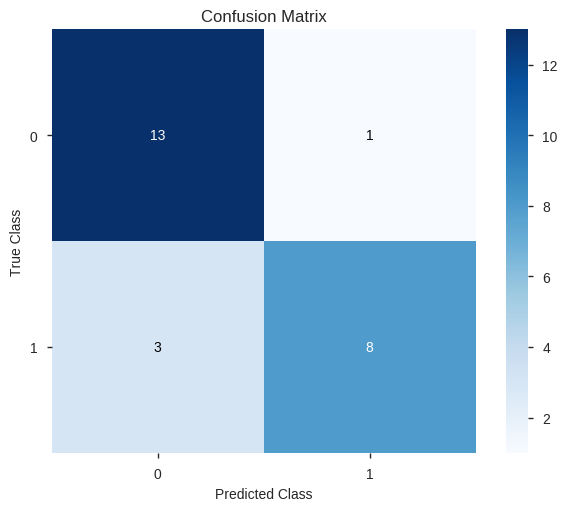

In [58]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

# Install library if needed
#pip install scikit-plot
import scikitplot as skplt

y_pred = finalmodel.predict(X_test)
validation_score = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

<div class="alert alert-warning">
<b>ACTION:  ROC Curve </b> 

<p> Comment on the performance of your final algorithm. Repeat analysis from earlier in the Notebook if necessary. </p>

<p> Explain any observations about the ROC results. </p>

</div>

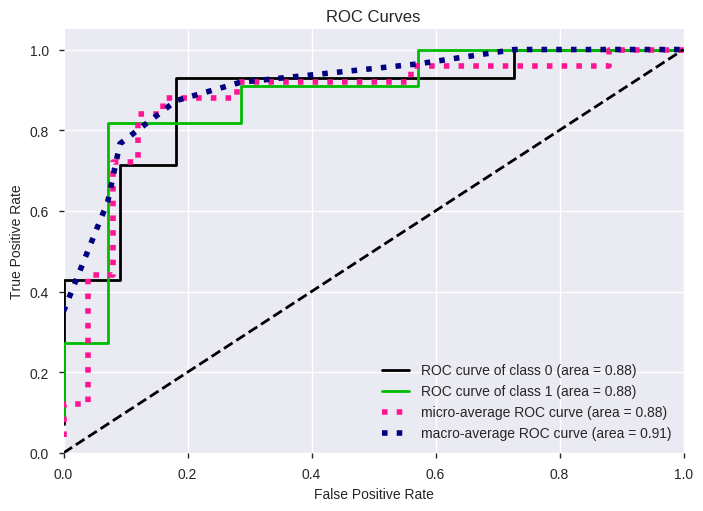

In [59]:
# Plot ROC Curves for each class
y_true = y_test
y_probas = finalmodel.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

<div class="alert alert-warning">
<b>ACTION:  Feature importance</b> 

<p> Where possible, comment on the feature selection and performance of your final algorithm. Repeat analysis from earlier in the Notebook if necessary. </p>

<p> Explain any observations about the sensitivity of your final analysis. </p>

</div>

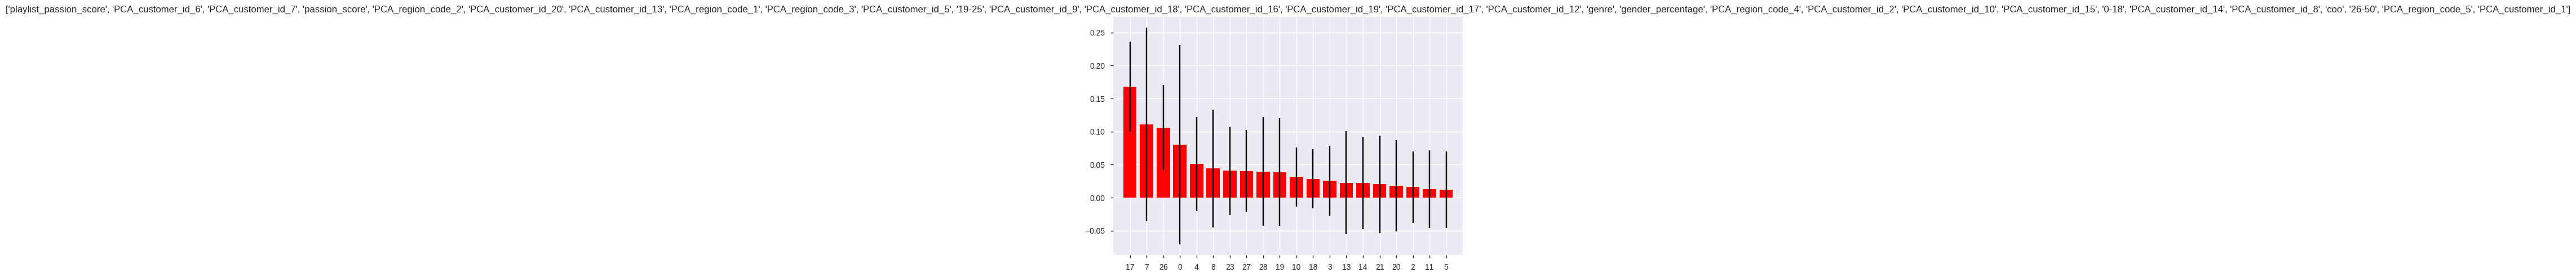

In [60]:
# Feature importance analysis RandomForestsClassifier
skplt.estimators.plot_feature_importances(finalmodel_rf, features)
plt.show()

For our RandomForestClassifier.

Features of importance include a lot of the components of customer ID PCA, the kind age group (0-18) and the young adults age group (19-25).

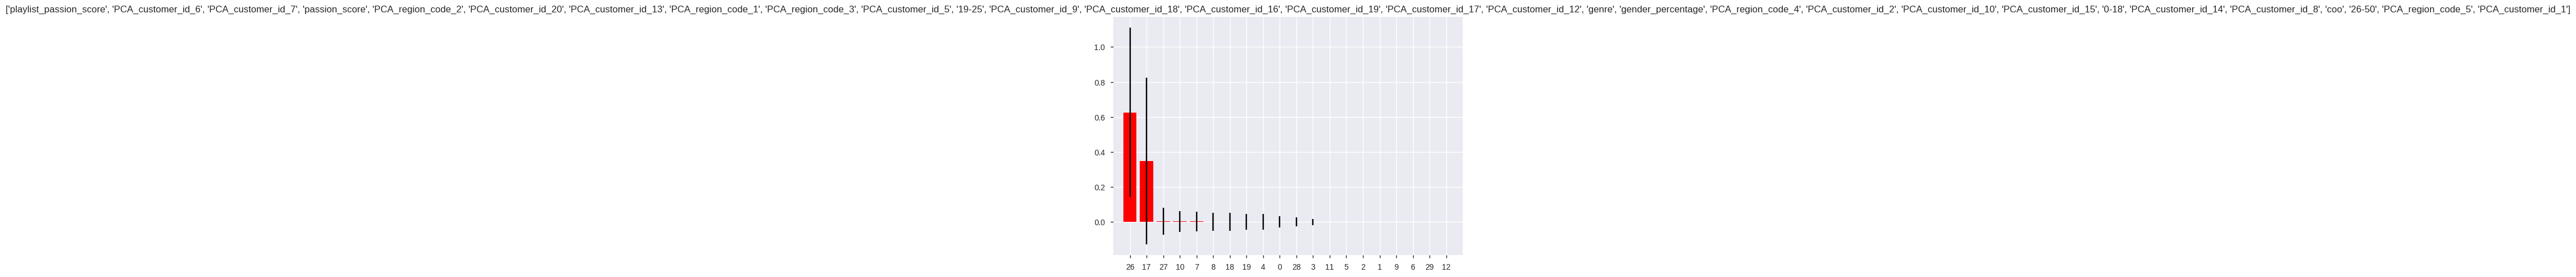

In [61]:
# Feature importance analysis AdaBoostClassifier
skplt.estimators.plot_feature_importances(finalmodel_ada, features)
plt.show()

For AdaBoostClassifier only the kids age group and the 14th component of customer ID are significant. This is not a good indication that the model is performing.

As was noted above, this model wouldn't have been selected if we had the time to do a second pass over the previous stages.

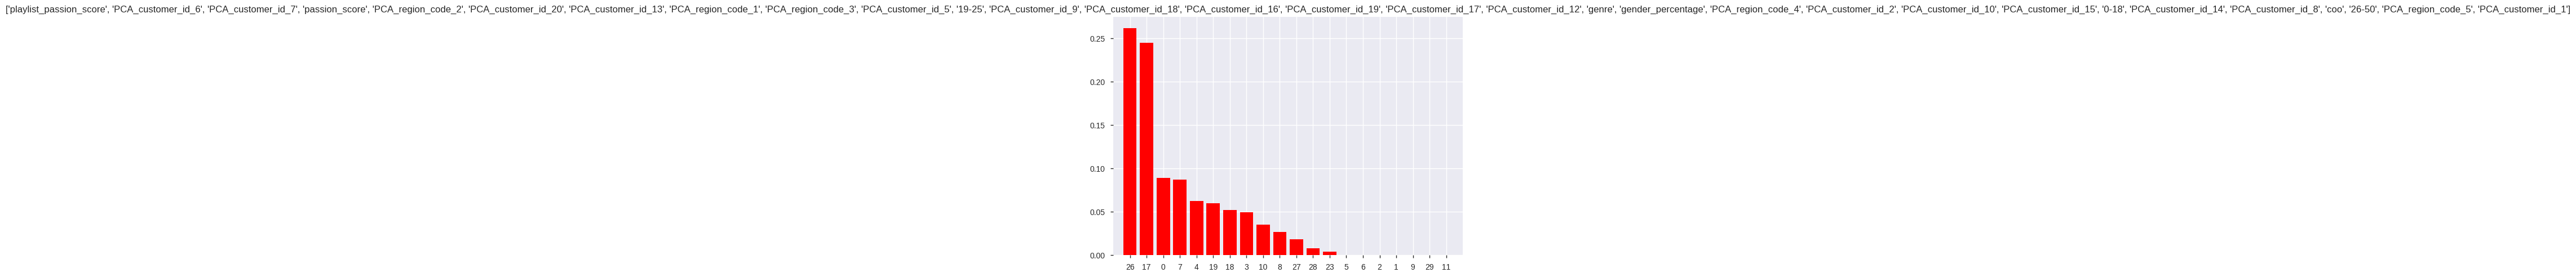

In [62]:
# Feature importance analysis XGBoostClassifier
skplt.estimators.plot_feature_importances(finalmodel_xgb, features)
plt.show()

Feature importance here is very similar to that of the RandomForestClassifier. 

## Summary 

In short, we explored the raw data Spotify collects from its customers. Identified potentially good candidate predictors for the future success of an artist and generated features and aggregate metrics for those. PCA was utilized to reduce the dimensonality of some of those features. We processed the dataset and converted it in a format that we could deploy ML models on. We tested various models, selected the ones performing best and focused more on fine tuning them to achieve better results. Consequently we explored the best possible way to create and ensemble from those models, which eventually significantly outperformed any single model. 

Some of the key features that constitute good predictors were identified, those being mainly an artist's passion score, some specific customer pool, the country of origin of an artist and a key demografic audiences of each artist, specifically the 19-25 year old age group of young adults. 

This analysis can be easily translated into action. The final model can be deployed directly on new artist data to identify if they are highly likely to succeed or not. If yes then Spotify can opt to promote them directly through featuring them in key playlists. Whether this advertising campaign strategy is cost-efficient, is something that can be easily determined by using the confusion matrix above, assigning monetary values in terms of cost of advertising and promotion and revenue generated for Spotify through the success of an artist for true/false positives/negatives and calculating the expected total revenue increase/loss. 